## 1. Set path to a data file

In [1]:
import catdegus.active_learning.acquisition as aq
import catdegus.active_learning.gaussian_process as gpc
import catdegus.visualization.plot as pl

# Define the home directory and path to data
# Target metric: initial CO2 conversion
path = "./20250228_sheet_for_ML_unique.xlsx"

/Users/djayshin/miniconda3/envs/catdegus_dev/lib/python3.13/site-packages/tqdm-4.67.1-py3.13.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Preprocess data and train a Gaussian process model 
* `path`: path to data file (excel)

In [2]:
# Train the Gaussian Process model
GP = gpc.GaussianProcess()
GP.preprocess_data_at_once(path=path,
                           target='CO2 Conversion (%)_initial value',
                           x_range_min=[300, 0.1, 0.005, 0], x_range_max=[550, 1.0, 0.02, 1])
GP.train_gp()

self.df.dtypes: reaction_temp                         int64
Rh_weight_loading                   float64
Rh_total_mass                       float64
synth_method                          int64
CO2 Conversion (%)_initial value    float64
dtype: object
numerical_features (selected):  ['reaction_temp', 'Rh_weight_loading', 'Rh_total_mass', 'synth_method']
categorical_features (selected):  []


/Users/djayshin/Dropbox/0.Dongjae/04.SUNCAT@SLAC,Standford(2402~)/231128_research/240602_ML_codes/CatDegUS/catdegus/active_learning/gaussian_process.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df.replace(
/Users/djayshin/miniconda3/envs/catdegus_dev/lib/python3.13/site-packages/scikit_learn-1.7.0-py3.13-macosx-11.1-arm64.egg/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/Users/djayshin/miniconda3/envs/catdegus_dev/lib/python3.13/site-packages/botorch-0.14.0-py3.13.egg/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (lengthscale_prior): LogNormalPrior()
    (raw_lengthscale_constraint): GreaterThan(2.500E-02)
  )
  (outcome_transform): Standardize()
)

## 3. Construct a discrete grid for the optimization of an acquisition function
* Acquisition function to optimize is set by choosing `optimize_*` method.
* Then, maximizer condition of the selected acquisition function (`PosteriorStandardDeviation` in this example) is printed.
* Using `optimize_posterior_std_dev_discrete_batch()`, q-batch sampling for specific synthesis method and temperature (two equality contraints) can be performed. Sampled points are approximated to the closest grid points.

In [ ]:
# Construct the discrete grid for optimization
Grid = aq.DiscreteGrid(
    GP=GP,
    x_range_min=[300, 0.1, 0.005, 0], x_range_max=[550, 1.0, 0.02, 1], x_step=[50, 0.1, 0.0025, 1]
)
Grid.construct_grid()

# 1) sequetial sampling
Grid.optimize_posterior_std_dev_discrete(synth_method='NP', n_candidates=5)
# Grid.optimize_upper_confidence_bound_discrete(synth_method_num='NP', n_candidates=5)

# 2) batch sampling with two equality constraints (synthesis method and temperature)
Grid.optimize_posterior_std_dev_discrete_batch(
    synth_method='NP',
    temperature=300,
    n_candidates=4,
    )

840 combinations are possible in the constructed grid.
Temperature 300 C is transformed to 0.0.

Batch candidates shape: torch.Size([4, 4])
Acquisition values shape: torch.Size([])
Acquisition values: 1.5431932904004633

Batch candidates:
tensor([[0.0000e+00, 6.6274e-01, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 3.6561e-01, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 4.8401e-01, 1.4607e-13, 1.0000e+00]])

Batch candidates (closest grid points):
tensor([[0.0000, 0.6667, 1.0000, 1.0000],
        [0.0000, 0.3333, 1.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [0.0000, 0.4444, 0.0000, 1.0000]], dtype=torch.float64)


,reaction_temp,Rh_weight_loading,Rh_total_mass,synth_method
48,300,0.7,0.020,1
27,300,0.4,0.020,1
69,300,1.0,0.020,1
28,300,0.5,0.005,1


## 4. Plot the acquisition function

### a. 2D distribution of the acquisition function for selected temperatures and synthesis method
* The acquisition function was determined by a `DiscreteGrid` instance, e.g., `PosteriorStandardDeviation`
* You can toggle between showing 2D plot immediately and saving the figure as a `.png` file.
* Corresponding JSON output file is also generated upon running `plot_2d_acquisition_function()` or `plot_3d_acquisition_function()`.

No maximizer found for synthesis method NP at temperature 300


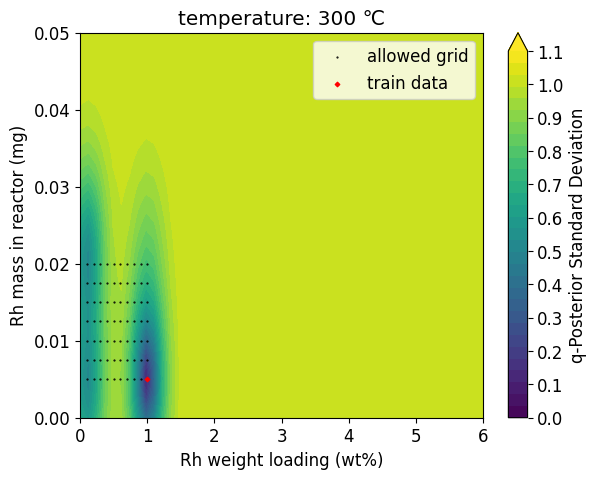

No maximizer found for synthesis method NP at temperature 350


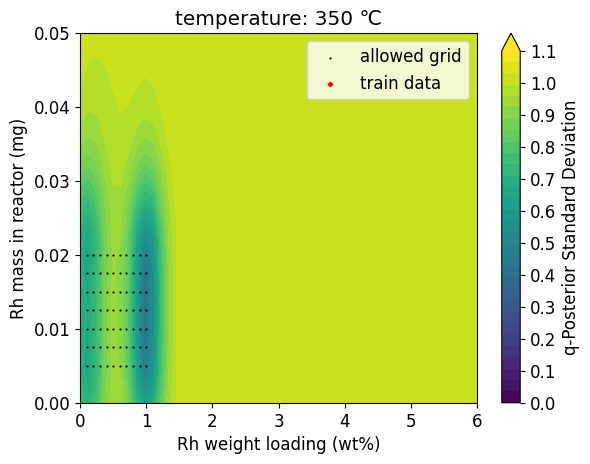

In [18]:
# Plot the acquisition function
Plot = pl.Plotter(GP=GP, Grid=Grid)

Plot.plot_2d_acquisition_function(
    synth_method='NP',
    acq_max=1.1,
    n_levels=32,
    temperature_list=[300, 350],# 400, 450, 500, 550],
    mode='custom', #'boundary',
    custom_range=(0.0, 6.0, 0.0, 0.05),  # Custom range for contour plot
    contour_resolution=50,
    plot_allowed_grid=True,
    plot_train=True,
    show=True
)

### b. 3D distribution of the acquisition function for each synthesis method

Maximizer for synthesis method NP: {'reaction_temp': 550.0, 'Rh_weight_loading': 1.0, 'Rh_total_mass': 0.005, 'synth_method': 1.0}


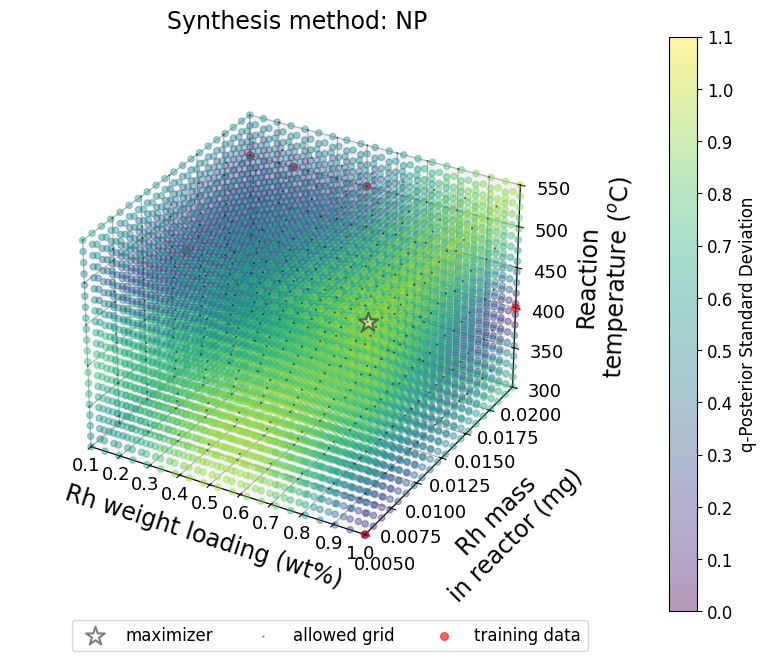

In [ ]:
Plot.plot_3d_acquisition_function(
    synth_method='NP',
    acq_max=1.1,
    mode='boundary', #'custom',
    custom_range=(0.0, 6.0, 0.0, 0.05, 300, 550),  # Custom range for contour plot
    contour_resolution=20,
    plot_allowed_grid=True,
    plot_train=True,
    show=True
)

In [ ]:
Grid.optimize_posterior_std_dev_discrete(synth_method='WI', n_candidates=5) # recalculate maximizer for WI

Plot.plot_3d_acquisition_function(
    synth_method='WI',
    acq_max=1.1,
    mode='boundary', #'custom',
    custom_range=(0.0, 6.0, 0.0, 0.05, 300, 550),  # Custom range for contour plot
    contour_resolution=20,
    plot_allowed_grid=True,
    plot_train=True,
    show=False
)

Maximizer for synthesis method WI: {'reaction_temp': 550.0, 'Rh_weight_loading': 1.0, 'Rh_total_mass': 0.005, 'synth_method': 0.0}


<Figure size 800x650 with 0 Axes>